<a href="https://colab.research.google.com/github/rajkgoel/AW-Internet-Sales1/blob/master/Scaler_Ecomm_Case_Study1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# Global data that are used across the case-study solutions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Read all the data from the drive
url = "https://drive.google.com/uc?"

customer_data_df = pd.read_excel(f"{url}id=1rqihT647UW9HEmERxCrTJrcZZ9xE5TEi")
discount_coupon_df = pd.read_csv(f"{url}id=1CfORUKckP7Qi9swmCe8XEgLLWnpKl4eE")
marketing_spend_df = pd.read_csv(f"{url}id=1hjHgCluvPEUfrp9w-_-73ch0d9SK6FHf")
online_sales_df = pd.read_csv(f"{url}id=1ZvQn7-UtGSdJa3H9zM4ve_uzACFAzF0Z")
tax_amount_df = pd.read_excel(f"{url}id=1tqJmtKcfhiEJXYVV21ybnD4UaXYW9r4v")

month_map = { 1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July",
             8: "August", 9: "September", 10: "October", 11: "November", 12: "December" }

# Convert Transaction Date -
# PS:: Since the data is provided for a single year, using the Transaction_Month for all further analysis,
# otherwise Transaction_YearMonth could have been used
online_sales_df["Transaction_Date"] = pd.to_datetime(online_sales_df["Transaction_Date"], format="%m/%d/%Y")
online_sales_df["Transaction_Month"] = online_sales_df["Transaction_Date"].dt.month
online_sales_df["Month"] = online_sales_df["Transaction_Month"].map(month_map)
online_sales_df["Amount"] = online_sales_df["Quantity"] * online_sales_df["Avg_Price"] + online_sales_df["Delivery_Charges"]

In [69]:
# 1. Identify the months with the highest and lowest customer acquisition count. What strategies could be implemented to address
#   the fluctuations and ensure consistent growth throughout the year?
#  - Hint: Think about what “acquisition” really means — it’s the first time a customer makes a purchase.
#     You’ll need to find the earliest transaction date for each unique customer using appropriate grouping and aggregation methods.
#     This will help you isolate the first purchase instance for each customer in the dataset.
#  - Hint: Once you’ve identified each customer's first transaction date, extract the month from that date. Use this to group customers
#     by their acquisition month and count how many customers fall into each group. This will give you the monthly trend of customer acquisition.

# Find Earliest Transaction Date for each customer
earliest_txn = (online_sales_df.groupby("CustomerID")["Transaction_Date"].min().reset_index(name="Earliest_Transaction_Date"))

# Convert dates to months
earliest_txn["Transaction_Month"] = earliest_txn["Earliest_Transaction_Date"].dt.month
monthly_acquisitions = earliest_txn.groupby("Transaction_Month")["CustomerID"].count().reset_index(name="Acquisitions")
monthly_acquisitions["Month"] = monthly_acquisitions["Transaction_Month"].map(month_map)

# Months with Highest & Lowest Acquisitions
highest = monthly_acquisitions[monthly_acquisitions['Acquisitions'] == monthly_acquisitions['Acquisitions'].max()]
highest_month = highest["Month"].iloc[0]
lowest = monthly_acquisitions[monthly_acquisitions['Acquisitions'] == monthly_acquisitions['Acquisitions'].min()]
lowest_month = lowest['Month'].iloc[0]

# Next 2 months with lowest acquisitions
next_2 = monthly_acquisitions.sort_values(by='Acquisitions', ascending=True).iloc[1:3][['Month']]

print(f"""
{highest_month} records the highest number of customer acquisitions, while {lowest_month} has the lowest acquisition levels,
highlighting an opportunity for improvement. To boost customer acquisition in {lowest_month}, targeted strategies such as
additional discounts or promotional coupons can be introduced. Similar incentive-based campaigns may also be effective in
{next_2['Month'].iloc[0]} and {next_2['Month'].iloc[1]}, which are the next two lowest-performing months in terms of acquisitions.
""")


January records the highest number of customer acquisitions, while November has the lowest acquisition levels, 
highlighting an opportunity for improvement. To boost customer acquisition in November, targeted strategies such as 
additional discounts or promotional coupons can be introduced. Similar incentive-based campaigns may also be effective in 
September and October, which are the next two lowest-performing months in terms of acquisitions.



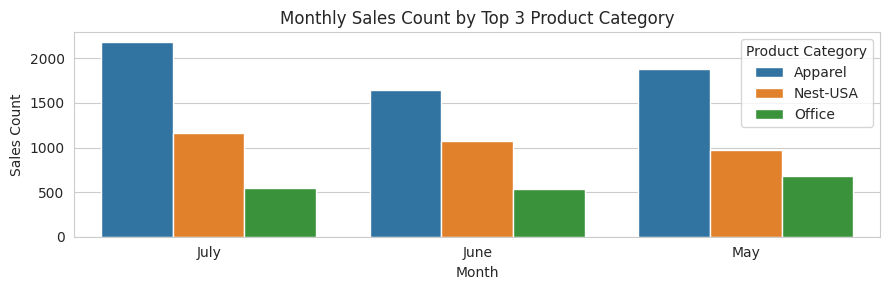


Above chart shows that the same product category was sold the most in Top 3 months of retention.




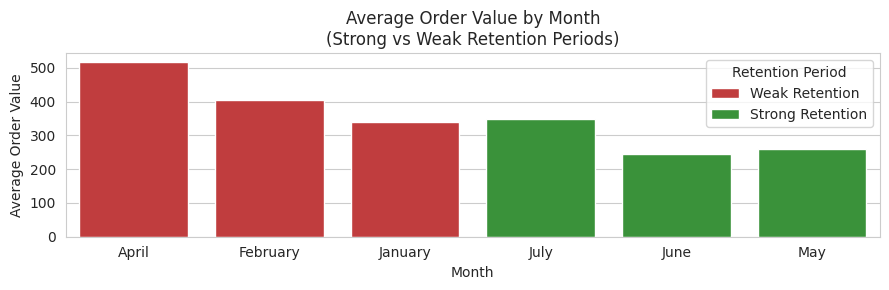


The analysis indicates that during strong retention periods, customers tend to place a higher number of lower-value orders,
whereas weak retention periods are characterized by fewer but higher-value purchases. Notably, the same product category emerges as
the top-selling category across the top three retention months, suggesting consistent customer preference.

This presents an opportunity to strengthen retention during weaker periods by introducing targeted discounts or bundled offers on
lower-value products within this popular category, encouraging repeat purchases and re-engaging customers more effectively.



In [70]:
# 2. Analyze customer behavior during high-retention months and suggest ways to replicate this success throughout the year.
# Hint: For periods identified with strong retention, delve into the characteristics of purchases made during those times.
# What product types, discount applications, or transaction values were common?
# Hint: Think about how these successful behaviors or conditions could be fostered in other months.

# Find monthly customers
retention_data = []
monthly_customers = (online_sales_df.groupby("Transaction_Month")["CustomerID"].apply(set).sort_index())
months = monthly_customers.index.tolist()

# Find retention data for each month
for i in range(len(months) - 1):
    month_x = months[i]
    month_next = months[i + 1]

    customers_x = monthly_customers[month_x]
    customers_next = monthly_customers[month_next]

    retained_customers = customers_x.intersection(customers_next)

    retention_rate = (
        len(retained_customers) / len(customers_x)
        if len(customers_x) > 0 else 0
    )
    retention = {
        "Month": month_x,
        "Next_Month": month_next,
        "Customers_Month_X": len(customers_x),
        "Retained_Customers": len(retained_customers),
        "Retention_Rate": round(retention_rate, 3)
    }
    retention_data.append(retention)

retention_data = pd.DataFrame(retention_data)
retention_data["Month"] = retention_data["Month"].map(month_map)
retention_data["Next_Month"] = retention_data["Next_Month"].map(month_map)

# Get Top 3 products from Top 3 retention periods
strongest_retention = retention_data.sort_values(by="Retention_Rate")[-3:]
merged_sales_df = strongest_retention.merge(online_sales_df, on="Month", how="inner")

top3_product_category = (merged_sales_df
                         .groupby(["Month", "Product_Category"])["Product_Category"]
                         .count()
                         .reset_index(name="Sales_Count")
                         .sort_values(["Month", "Sales_Count"], ascending=[True, False])
                         .groupby("Month")
                         .head(3))

top3_product_category
plt.figure(figsize=(9, 3))
sns.barplot(
    data=top3_product_category,
    x="Month",
    y="Sales_Count",
    hue="Product_Category"
)

plt.title("Monthly Sales Count by Top 3 Product Category")
plt.xlabel("Month")
plt.ylabel("Sales Count")
plt.legend(title="Product Category")
plt.tight_layout()
plt.show()

print("\nAbove chart shows that the same product category was sold the most in Top 3 months of retention.\n\n")

# Get Average Order values for Strongest & Weakest periods
orders = online_sales_df.groupby("Transaction_ID")["Amount"].sum().reset_index(name="Order_Total")
online_sales_orders = orders.merge(online_sales_df, on="Transaction_ID", how="inner")[[ "Month", "Order_Total"]]
strong_period_orders = strongest_retention.merge(online_sales_orders, on="Month", how="inner")[["Month", "Retention_Rate", "Order_Total"]]

weakest_retention = retention_data.sort_values(by="Retention_Rate")[:3]
weak_period_orders = weakest_retention.merge(online_sales_orders, on="Month", how="inner")[["Month", "Retention_Rate", "Order_Total"]]

strong_period_orders["Period"] = "Strong Retention"
weak_period_orders["Period"] = "Weak Retention"

comparison_df = pd.concat([strong_period_orders, weak_period_orders])
distinct_period_month = comparison_df[["Period", "Month"]].drop_duplicates()

summary_df = (
    comparison_df
    .groupby("Month")["Order_Total"]
    .mean()
    .reset_index(name="Avg_Order_Value")
)
summary_df = summary_df.merge(distinct_period_month, on="Month", how="inner")
sns.set_style("whitegrid")

plt.figure(figsize=(9, 3))

sns.barplot(
    data=summary_df,
    x="Month",
    y="Avg_Order_Value",
    hue="Period",
    palette={
        "Strong Retention": "#2ca02c",  # green
        "Weak Retention": "#d62728"     # red
    }
)

plt.title("Average Order Value by Month\n(Strong vs Weak Retention Periods)")
plt.xlabel("Month")
plt.ylabel("Average Order Value")

plt.legend(title="Retention Period")
plt.tight_layout()
plt.show()

print("""
The analysis indicates that during strong retention periods, customers tend to place a higher number of lower-value orders,
whereas weak retention periods are characterized by fewer but higher-value purchases. Notably, the same product category emerges as
the top-selling category across the top three retention months, suggesting consistent customer preference.

This presents an opportunity to strengthen retention during weaker periods by introducing targeted discounts or bundled offers on
lower-value products within this popular category, encouraging repeat purchases and re-engaging customers more effectively.
""")

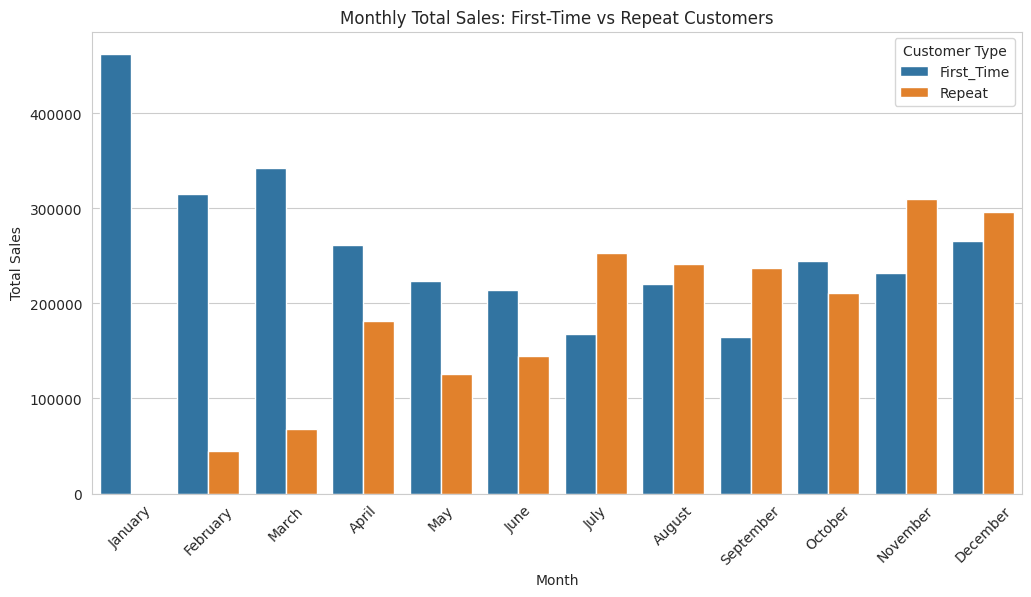


The chart shows a clear seasonal shift in revenue contribution. First-time customers drive higher sales in the early months of the year,
while repeat customers contribute more significantly from July onward.

This indicates that customer retention strengthens in the second half of the year, especially during November and December, making repeat
customers the primary driver of revenue during peak periods.



In [71]:
# 3. Compare the revenue generated by new and existing customers month-over-month. What does this trend suggest about the balance between
# acquisition and retention efforts?
# Hint: To compare behavior between newly acquired and retained users, you first need to identify for each month which customers are
#   visiting for the first time, and which ones are repeat visitors. This can be done by maintaining a rolling list of previously seen customers
#   and checking for presence.
# Hint: Once you’ve split customers into new and existing for each month, use this classification to filter the dataset and sum up the revenue
#   (e.g., invoice amounts) generated by each group. Visualizing this trend can help you assess whether your growth is being driven by
#   acquisition or loyalty.

first_purchase = (
    online_sales_df
    .groupby("CustomerID")["Transaction_Month"]
    .min()
    .reset_index(name="First_Purchase_Month")
)
sales_df = online_sales_df.merge(first_purchase, on="CustomerID", how="left")
sales_df["Customer_Type"] = np.where(
    sales_df["Transaction_Month"] == sales_df["First_Purchase_Month"],
    "First_Time",
    "Repeat"
)

monthly_sales_by_type = (
    sales_df
    .groupby(["Transaction_Month", "Customer_Type"])["Amount"]
    .sum()
    .reset_index(name="Total_Sales")
)

monthly_sales_by_type["Month"] = monthly_sales_by_type["Transaction_Month"].map(month_map)
monthly_sales_by_type[:25]

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

sns.barplot(
    data=monthly_sales_by_type,
    x="Month",
    y="Total_Sales",
    hue="Customer_Type"
)

plt.title("Monthly Total Sales: First-Time vs Repeat Customers")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.legend(title="Customer Type")
plt.xticks(rotation=45)

plt.show()

print(f"""
The chart shows a clear seasonal shift in revenue contribution. First-time customers drive higher sales in the early months of the year,
while repeat customers contribute more significantly from July onward.

This indicates that customer retention strengthens in the second half of the year, especially during November and December, making repeat
customers the primary driver of revenue during peak periods.
""")


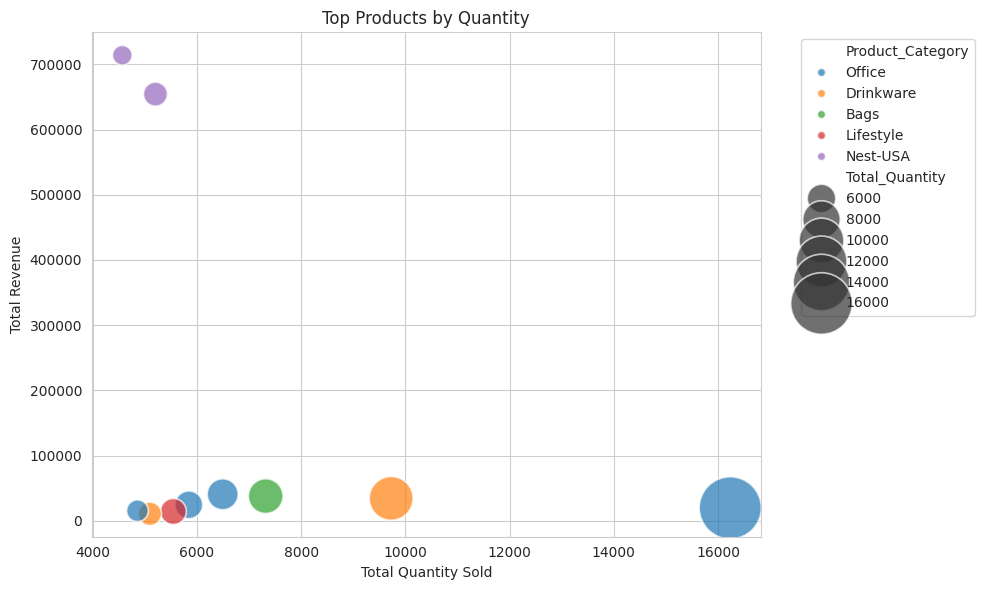


    The top three product categories by quantity sold are Office, Drinkware, and Nest-USA.
    These categories dominate sales volume, suggesting strong customer demand and repeat purchases.
    Ensuring optimal stock levels and focused promotional strategies for these categories can help
    maximize revenue and improve customer satisfaction.
    


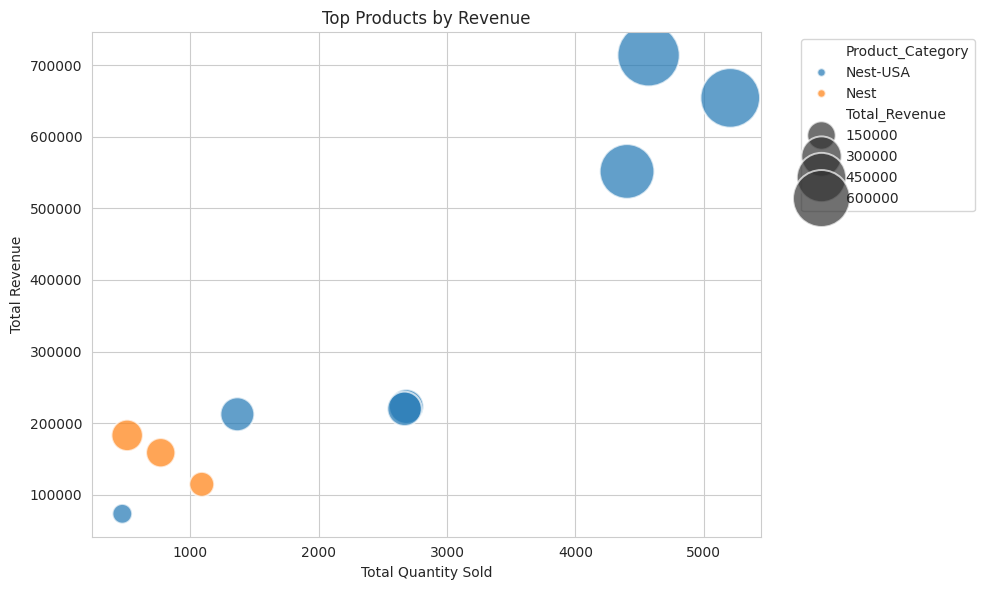


    The top revenue-generating categories are Nest-USA and Nest.
    These categories contribute disproportionately to total revenue, suggesting premium pricing,
    higher margins, or strong brand value, and should be prioritized for promotions and visibility.
    


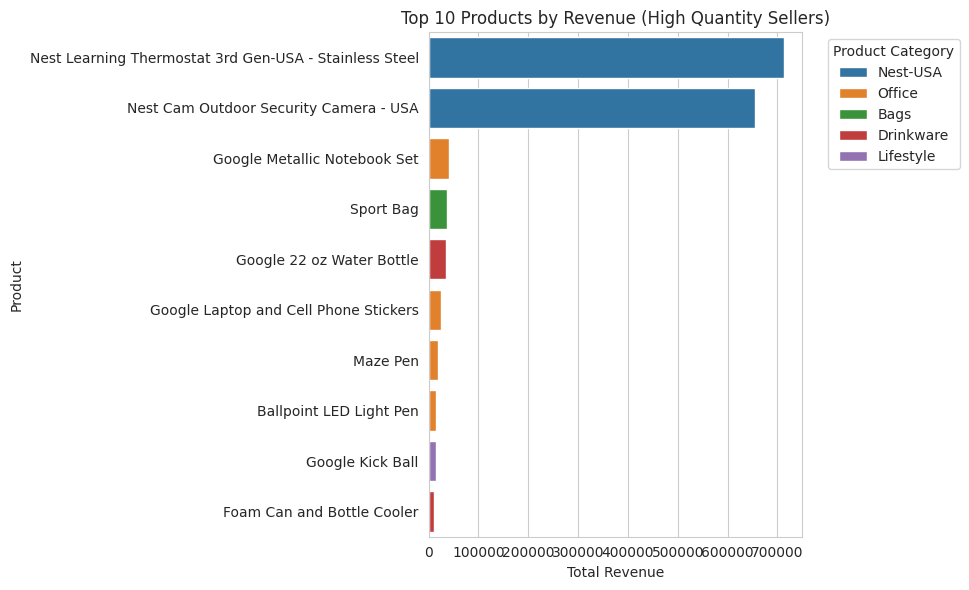


    The leading product categories among top-performing products are - 
      Office, f"Nest-USA, and Drinkware.
    These products strike a balance between high sales volume and strong revenue contribution,
    making them strategic anchors for inventory planning and bundled marketing campaigns.
    


In [72]:
# 4. Identify the top-performing products and analyze the factors driving their success. How can this insight inform inventory
#   management and promotional strategies?
#   Hint: Identify products that excel in terms of both quantity sold and total revenue.
#   Hint: Explore their categories and descriptions to understand what might contribute to their success. Think about how this
#   information can guide stocking and marketing efforts.

product_performance = (
    online_sales_df
    .groupby(["Product_SKU", "Product_Description", "Product_Category"])
    .agg(
        Total_Quantity=("Quantity", "sum"),
        Total_Revenue=("Amount", "sum"),
        Avg_Price=("Avg_Price", "mean"),
        Orders=("Transaction_ID", "nunique")
    )
    .reset_index()
)

top_by_quantity = product_performance.sort_values("Total_Quantity", ascending=False).head(10)
top_by_revenue = product_performance.sort_values("Total_Revenue", ascending=False).head(10)
top_products = (product_performance[product_performance["Total_Quantity"].rank(ascending=False) <= 10]
                .sort_values("Total_Revenue", ascending=False))

# Plot the chart for Top sales by quantity
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=top_by_quantity,
    x="Total_Quantity",
    y="Total_Revenue",
    size="Total_Quantity",
    hue="Product_Category",
    sizes=(200, 2000),
    alpha=0.7
)

plt.title("Top Products by Quantity")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Total Revenue")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

top_3_categories = top_by_quantity["Product_Category"].value_counts().head(3).index.tolist()
print(f"""
    The top three product categories by quantity sold are {top_3_categories[0]}, {top_3_categories[1]}, and {top_3_categories[2]}.
    These categories dominate sales volume, suggesting strong customer demand and repeat purchases.
    Ensuring optimal stock levels and focused promotional strategies for these categories can help
    maximize revenue and improve customer satisfaction.
    """
)


# Plot the chart for Top sales by revenue
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=top_by_revenue,
    x="Total_Quantity",
    y="Total_Revenue",
    size="Total_Revenue",
    hue="Product_Category",
    sizes=(200, 2000),
    alpha=0.7
)

plt.title("Top Products by Revenue")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Total Revenue")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

top_rev_categories = (
    top_by_revenue["Product_Category"]
    .value_counts()
    .head(2)
    .index
    .tolist()
)

print(f"""
    The top revenue-generating categories are {top_rev_categories[0]} and {top_rev_categories[1]}.
    These categories contribute disproportionately to total revenue, suggesting premium pricing,
    higher margins, or strong brand value, and should be prioritized for promotions and visibility.
    """
)


# Plot the chart for Top Sellers
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_products,
    y="Product_Description",
    x="Total_Revenue",
    hue="Product_Category",
    dodge=False
)

plt.title("Top 10 Products by Revenue (High Quantity Sellers)")
plt.xlabel("Total Revenue")
plt.ylabel("Product")

plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

top_product_categories = (
    top_products["Product_Category"]
    .value_counts()
    .head(3)
    .index
    .tolist()
)

print(
    f"""
    The leading product categories among top-performing products are -
      {top_product_categories[0]}, f"{top_product_categories[1]}, and {top_product_categories[2]}.
    These products strike a balance between high sales volume and strong revenue contribution,
    making them strategic anchors for inventory planning and bundled marketing campaigns.
    """
)



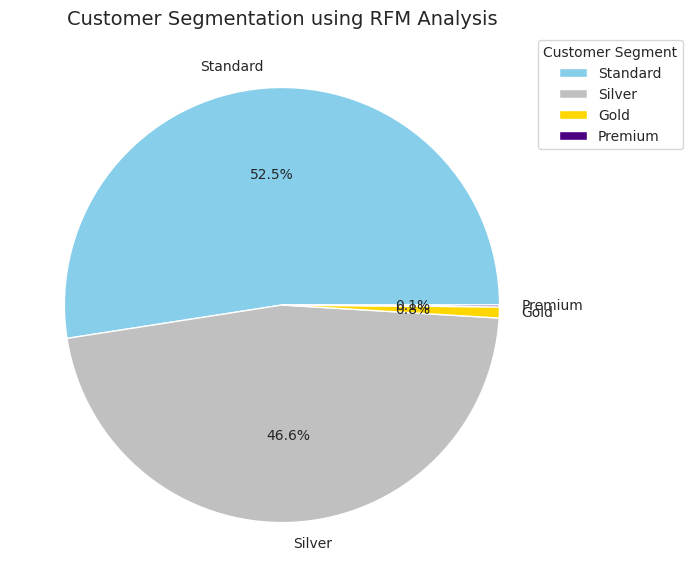

In [73]:
# 5. Segment customers into groups such as Premium, Gold, Silver, and Standard. What targeted strategies can be
# developed for each segment to improve retention and revenue? (Use RFM segmentation techniques)
# Hint: Apply RFM (Recency, Frequency, Monetary) principles to categorize customers.
# Hint: Define thresholds for Recency (how recently they purchased), Frequency (how often they purchase),
# and Monetary (how much they spend)to group customers into the specified segments.

def classify_customer(score):
    if score <= 6:
        return 'Standard'
    elif score <= 9:
        return 'Silver'
    elif score <= 11:
        return 'Gold'
    else:
        return 'Premium'

reference_date = online_sales_df["Transaction_Date"].max() + pd.Timedelta(days=1)

# Create RFM table
rfm = (
    online_sales_df
    .groupby("CustomerID")
    .agg(
        Recency=("Transaction_Date", lambda x: (reference_date - x.max()).days),
        Frequency=("Transaction_ID", "nunique"),
        Monetary=("Amount", "sum")
    )
    .reset_index()
)

rfm["R_Score"] = pd.cut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_Score"] = pd.cut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_Score"] = pd.cut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])
rfm["RFM_Score"] = rfm["R_Score"].astype(int) + rfm["F_Score"].astype(int) + rfm["M_Score"].astype(int)

rfm['Customer_Segment'] = rfm['RFM_Score'].apply(classify_customer)

segments = rfm["Customer_Segment"].value_counts()

segment_counts = rfm["Customer_Segment"].value_counts().reset_index()
segment_counts.columns = ["Segment", "Customers"]

# Plot the chart
color_map = {
    "Premium": "#4B0082",   # Indigo
    "Gold": "gold",
    "Silver": "silver",
    "Standard": "#87CEEB"
}

colors = [color_map[s] for s in segment_counts["Segment"]]

sns.set_style("whitegrid")

plt.figure(figsize=(7, 7))

wedges, texts, autotexts = plt.pie(
    segment_counts["Customers"],
    labels=segment_counts["Segment"],
    colors=colors,
    autopct="%1.1f%%"
)

plt.title("Customer Segmentation using RFM Analysis", fontsize=14)

plt.legend(
    wedges,
    segment_counts["Segment"],
    title="Customer Segment",
    loc="upper right",
    bbox_to_anchor=(1.25, 1)
)

plt.tight_layout()
plt.show()

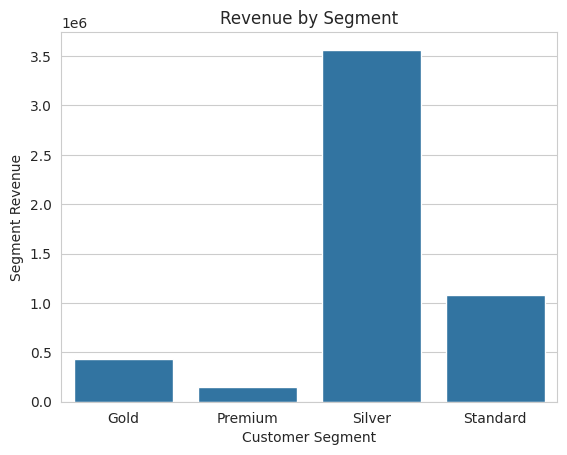


    The chart highlights that Silver customers contribute the highest share of revenue, followed by Standard customers, 
    while Gold and Premium segments contribute relatively less. This indicates an opportunity to prioritize retention and 
    upsell strategies for Silver customers, such as targeted loyalty programs and personalized offers, to move them into 
    higher-value tiers. At the same time, focused engagement and exclusive benefits for Gold and Premium customers can 
    help increase their spending frequency and maximize lifetime value, ensuring sustained growth across all segments.
    


In [74]:
# 6. Analyze the revenue contribution of each customer segment. How can the company focus its efforts on high-value segments
# while nurturing lower-value segments?
# Hint: Once segments are defined, quantify the revenue generated by each group.
# Hint: Consider how this understanding can help prioritize efforts and tailor strategies for maximizing value
# from high-tier customers while encouraging growth in lower tiers.

# PS: This segment uses rfm created by previous segment, run previous segment first to execute this
revenue_by_segment = rfm.groupby("Customer_Segment")["Monetary"].sum().reset_index(name="Segment_Revenue")
revenue_by_segment.head(20)

sns.set_style("whitegrid")
sns.barplot(data=revenue_by_segment,x="Customer_Segment",y="Segment_Revenue")
plt.ylabel("Segment Revenue")
plt.xlabel("Customer Segment")
plt.title("Revenue by Segment")
plt.show()

print("""
    The chart highlights that Silver customers contribute the highest share of revenue, followed by Standard customers,
    while Gold and Premium segments contribute relatively less. This indicates an opportunity to prioritize retention and
    upsell strategies for Silver customers, such as targeted loyalty programs and personalized offers, to move them into
    higher-value tiers. At the same time, focused engagement and exclusive benefits for Gold and Premium customers can
    help increase their spending frequency and maximize lifetime value, ensuring sustained growth across all segments.
    """)

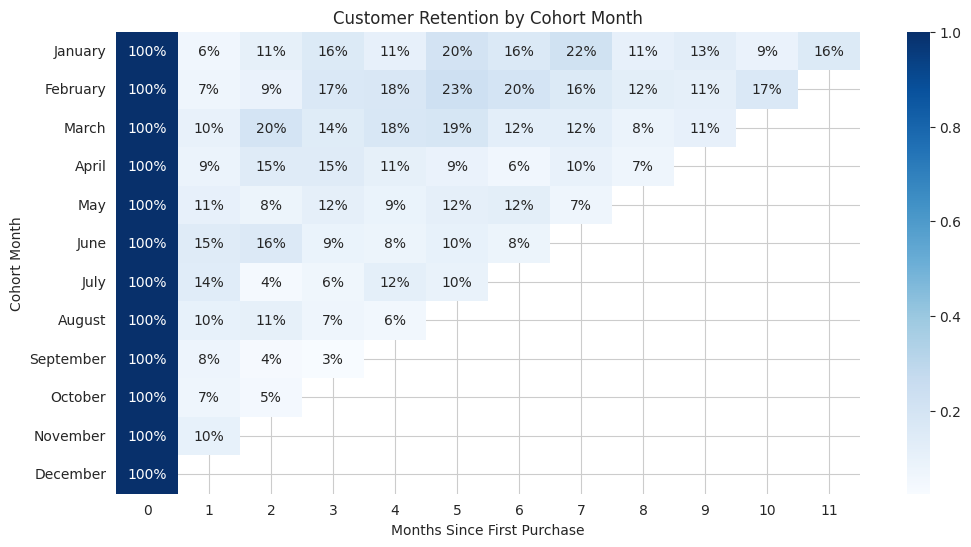


Highest retention is observed in January–March cohorts, showing stronger long-term engagement. Lowest retention is seen 
in September–November cohorts, with sharp drop-offs in early months.
To improve retention, focus on stronger onboarding and early engagement within the first 30–60 days. Use personalized offers, 
loyalty incentives, and value-driven messaging to reduce early churn. Optimizing acquisition channels can help attract 
higher-intent customers in weaker months.



In [75]:
# 7. Group customers by their month of first purchase and analyze retention rates over time. Which cohorts exhibit the
# highest and lowest retention rates? What strategies can be implemented to improve retention for weaker cohorts?
# Hint: Define cohorts based on the month of a customer's first purchase.
# Hint: Track the activity of these cohorts over subsequent months to observe retention patterns and identify which groups
# show stronger or weaker loyalty.

# sales_first_month = online_sales_df.groupby("CustomerID")["Transaction_Month"].min()
# sales_first_month.head(50)
# online_sales_df.head()

cohort_data = online_sales_df.copy()
cohort_data["Cohort_Month"] = cohort_data.groupby("CustomerID")["Transaction_Month"].transform("min")
cohort_data.query("Transaction_Month != Cohort_Month").head(30)
cohort_data["Cohort_Retention"] = (cohort_data["Transaction_Month"].astype(int) - cohort_data["Cohort_Month"].astype(int))
cohort_data = cohort_data.groupby(["Cohort_Month", "Cohort_Retention"])["CustomerID"].nunique().reset_index(name="Customers_Count")
cohort_pivot = cohort_data.pivot(index="Cohort_Month", columns="Cohort_Retention", values="Customers_Count")
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix.index = retention_matrix.index.map(
    lambda x: month_map[int(x)]
)


# Plot the Retention Chart
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention_matrix,
    annot=True,
    fmt=".0%",
    cmap="Blues"
)
plt.title("Customer Retention by Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.show()

print("""
Highest retention is observed in January–March cohorts, showing stronger long-term engagement. Lowest retention is seen
in September–November cohorts, with sharp drop-offs in early months.
To improve retention, focus on stronger onboarding and early engagement within the first 30–60 days. Use personalized offers,
loyalty incentives, and value-driven messaging to reduce early churn. Optimizing acquisition channels can help attract
higher-intent customers in weaker months.
""")

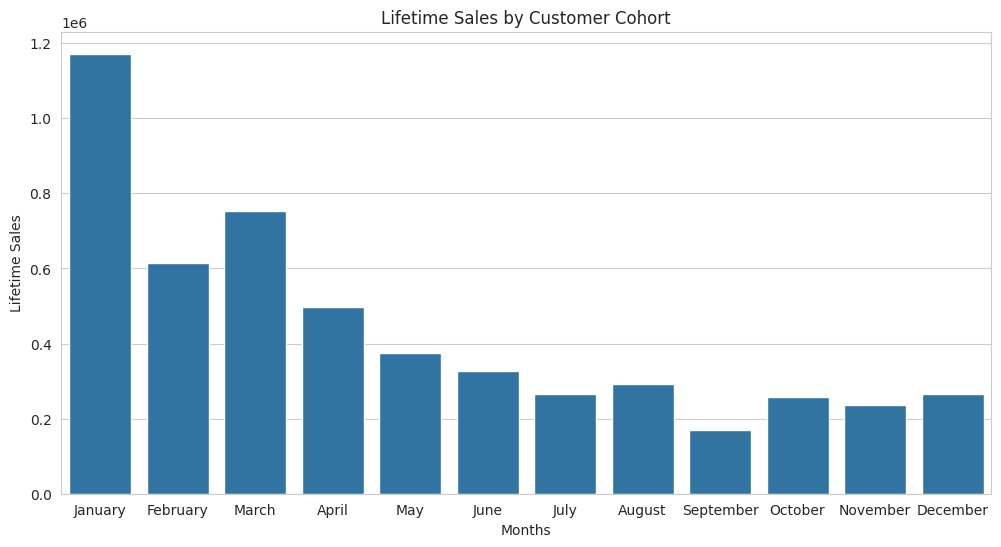


As evident from the chart, customers acquired during **January–March** generate the highest long-term value and demonstrate 
stronger retention. In contrast, customers acquired between **September–November** show the lowest retention and lifetime value. 
Focusing acquisition efforts and higher-quality campaigns during **January–March** can help maximize overall customer value, 
while improved onboarding and engagement strategies are needed to strengthen retention for late-year acquisitions.




In [76]:
# 8. Analyze the lifetime value of customers acquired in different months. How can this insight inform acquisition and retention strategies?
# Hint: Consider how to estimate the long-term value that customers acquired in different periods bring to the company.
# Hint: Think about how this insight can guide decisions on customer acquisition costs and retention investments.

cohort_data = online_sales_df.copy()
cohort_data["Cohort_Month"] = cohort_data.groupby("CustomerID")["Transaction_Month"].transform("min")
customer_lifetime_sales = cohort_data.groupby("CustomerID")["Amount"].sum().reset_index(name="Lifetime_Sales")
customer_lifetime_sales = customer_lifetime_sales.merge(cohort_data[["CustomerID", "Cohort_Month"]].drop_duplicates(), on="CustomerID", how="left")
customer_lifetime_sales.head(30)
cohort_lifetime_sales = customer_lifetime_sales.groupby("Cohort_Month")["Lifetime_Sales"].sum().reset_index(name="Lifetime_Sales")
cohort_lifetime_sales["Month_Name"] = cohort_lifetime_sales["Cohort_Month"].map(month_map)
cohort_lifetime_sales.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=cohort_lifetime_sales,x="Month_Name",y="Lifetime_Sales")
plt.xlabel("Months")
plt.ylabel("Lifetime Sales")
plt.title("Lifetime Sales by Customer Cohort")
plt.show()

print("""
As evident from the chart, customers acquired during **January–March** generate the highest long-term value and demonstrate
stronger retention. In contrast, customers acquired between **September–November** show the lowest retention and lifetime value.
Focusing acquisition efforts and higher-quality campaigns during **January–March** can help maximize overall customer value,
while improved onboarding and engagement strategies are needed to strengthen retention for late-year acquisitions.

""")

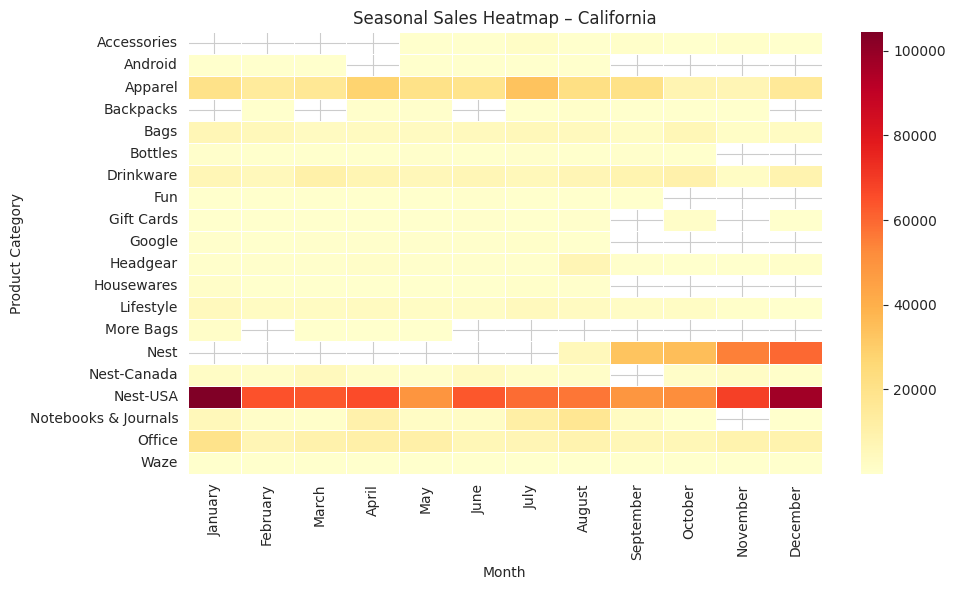


 California - Top 3 Products and their Peak Sales Months:
• Nest-USA sells the most in January (Total Sales: 104,336)
• Apparel sells the most in July (Total Sales: 33,836)
• Nest sells the most in December (Total Sales: 59,733)


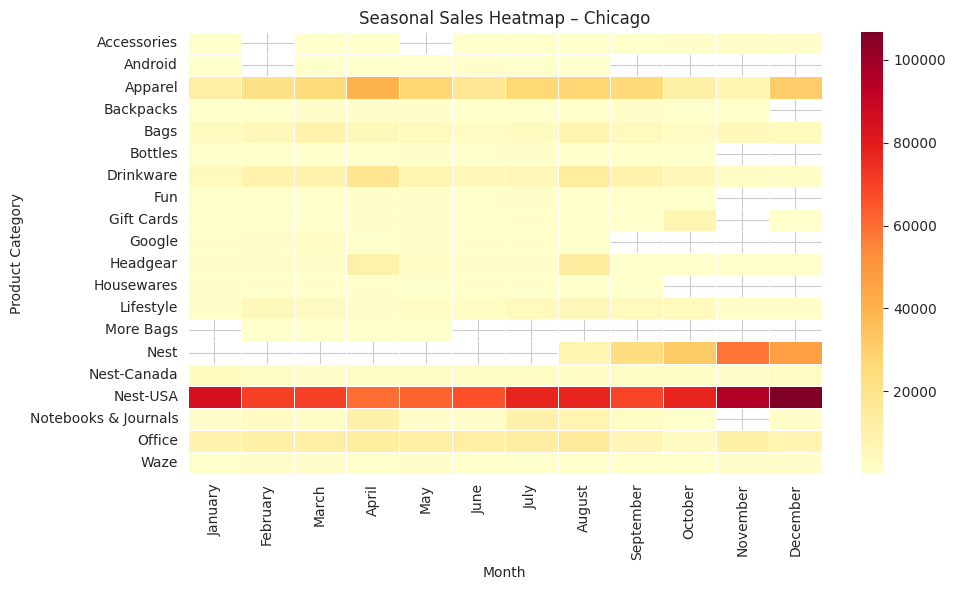


 Chicago - Top 3 Products and their Peak Sales Months:
• Nest-USA sells the most in December (Total Sales: 106,667)
• Apparel sells the most in April (Total Sales: 40,154)
• Nest sells the most in November (Total Sales: 58,443)


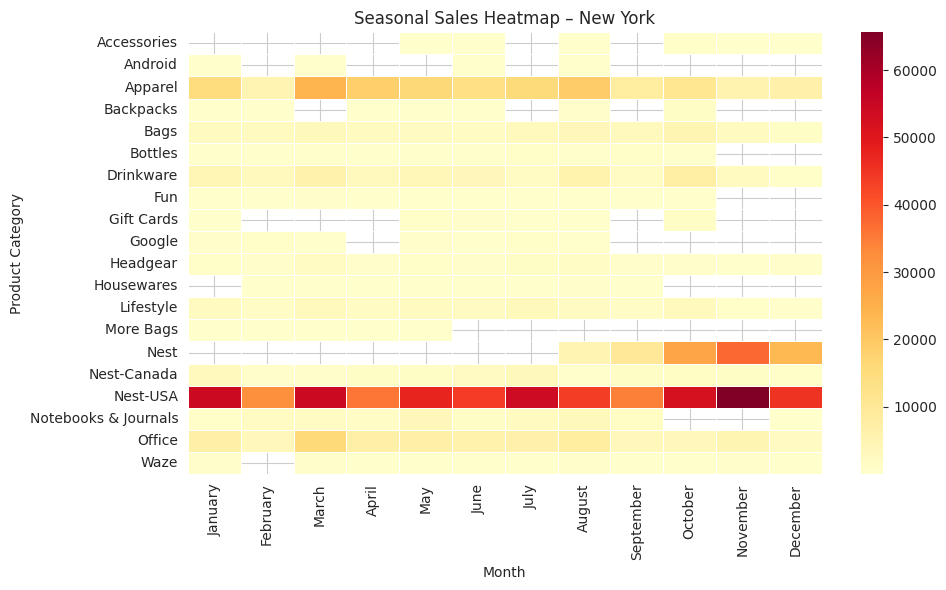


 New York - Top 3 Products and their Peak Sales Months:
• Nest-USA sells the most in November (Total Sales: 65,603)
• Apparel sells the most in March (Total Sales: 23,930)
• Nest sells the most in November (Total Sales: 37,458)


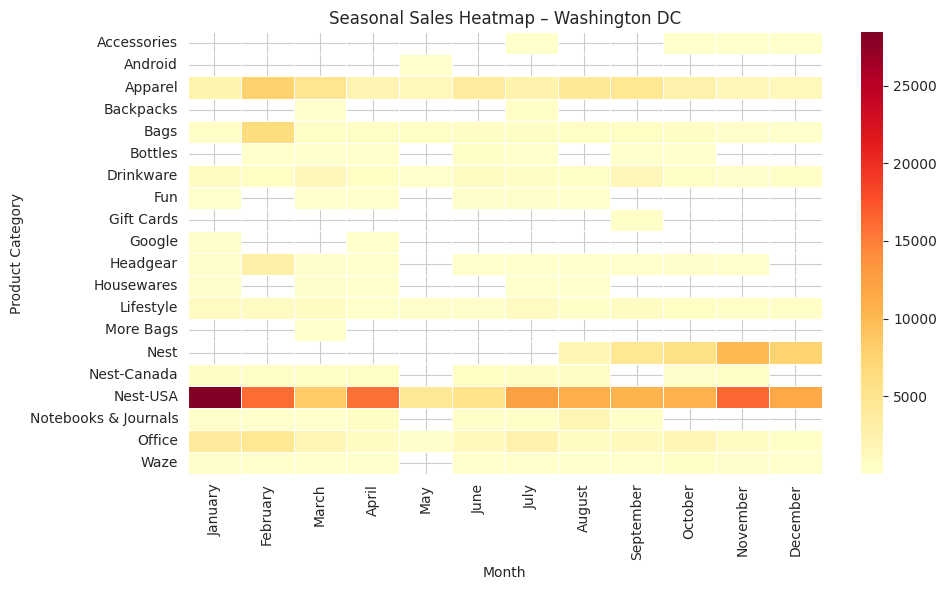


 Washington DC - Top 3 Products and their Peak Sales Months:
• Nest-USA sells the most in January (Total Sales: 28,425)
• Apparel sells the most in February (Total Sales: 7,696)
• Nest sells the most in November (Total Sales: 10,090)


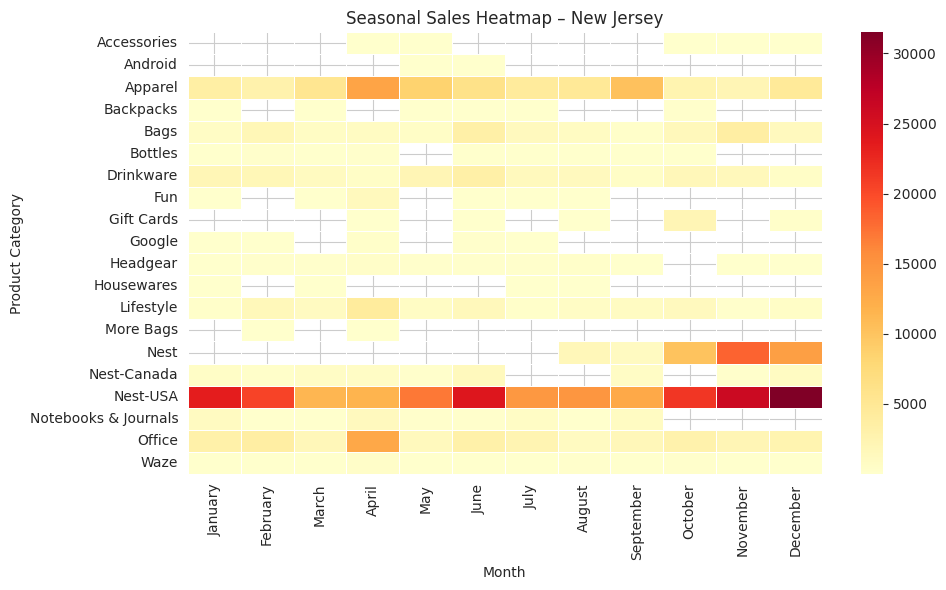


 New Jersey - Top 3 Products and their Peak Sales Months:
• Nest-USA sells the most in December (Total Sales: 31,507)
• Apparel sells the most in April (Total Sales: 13,340)
• Nest sells the most in November (Total Sales: 18,403)


In [77]:
# 9. Identify seasonal trends in sales by category and location. How can the company prepare for peak and off-peak seasons
# to maximize revenue?
# Hint: Analyze sales patterns across different product categories and locations throughout the year to identify recurring
# peaks and troughs.
# Hint: Consider how these seasonal insights can inform inventory management and promotional planning.

merged_df = online_sales_df.merge(customer_data_df, on="CustomerID", how="inner")
product_location_df = (merged_df.groupby(["Transaction_Month", "Location", "Product_Category"])["Amount"]
                       .sum().reset_index(name="Total_Sales"))
product_location_df.head()
# product_sales_df = (product_location_df.groupby("Product_Category")["Total_Sales"].sum().reset_index(name="Total_Sales")
# .sort_values(by="Total_Sales", ascending=False))
# product_sales_df.head(20)
product_location_df["Month"] = product_location_df["Transaction_Month"].map(month_map)
product_location_df = product_location_df.sort_values(by=["Transaction_Month"], ascending=[True])
product_location_df.head(30)

locations = product_location_df["Location"].unique()

# Plot the chart for each location
for location in locations:
  heatmap_df = (
    product_location_df[product_location_df["Location"] == location]
    .pivot_table(
        index="Product_Category",
        columns="Transaction_Month",
        values="Total_Sales",
        aggfunc="sum"
    )
    .sort_index(axis=1)   # sort months numerically
  )
  heatmap_df.columns = heatmap_df.columns.map(month_map)

  plt.figure(figsize=(10, 6))
  sns.heatmap(
      heatmap_df,
      cmap="YlOrRd",
      linewidths=0.5
  )

  plt.title(f"Seasonal Sales Heatmap – {location}")
  plt.xlabel("Month")
  plt.ylabel("Product Category")
  plt.tight_layout()
  plt.show()

  # ANALYTICS: Top 3 products & peak months
  top_products = (
      heatmap_df.sum(axis=1)
      .sort_values(ascending=False)
      .head(3)
      .index
  )

  print(f"\n {location} - Top 3 Products and their Peak Sales Months:")

  for product in top_products:
      peak_month_num = heatmap_df.loc[product].idxmax()
      peak_month_name = month_map.get(peak_month_num, peak_month_num)
      peak_sales = heatmap_df.loc[product].max()

      print(
          f"• {product} sells the most in {peak_month_name} "
          f"(Total Sales: {peak_sales:,.0f})"
      )

  print("=" * 120)



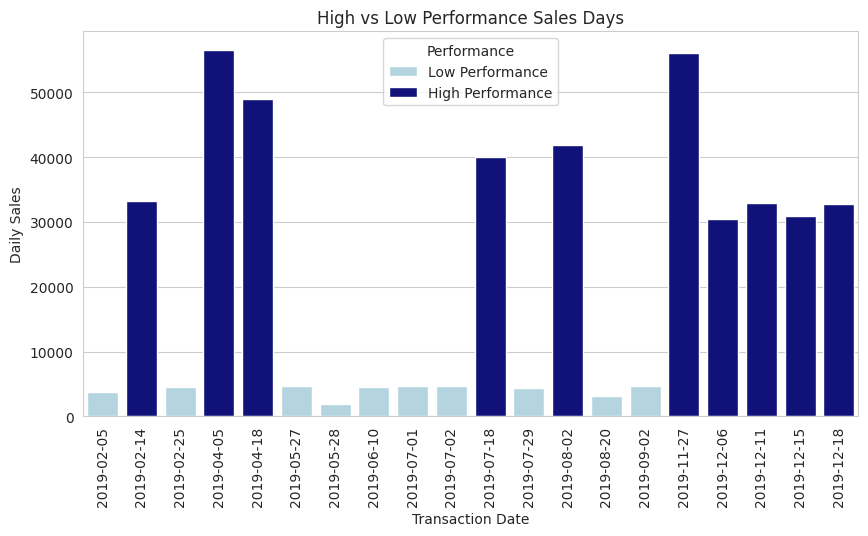


    Sales peaks are largely driven by holidays and seasonal events such as Diwali and year-end festivities. 
    To replicate this behavior on slow days, businesses can introduce flash sales and festival-themed micro-campaigns. 
    Targeted outreach through emails and notifications can recreate urgency and increase traffic. 
    Bundling offers, free shipping, and loyalty incentives help boost conversions during low-demand periods.
    


In [78]:
# 10. Analyze daily sales trends to identify high-performing and low-performing days. What strategies can be implemented to
# boost sales on slower days?
# Hint: Identify high-performing and low-performing days by analyzing daily sales data.
# Hint: Think about specific strategies that could stimulate sales during identified slower periods.

daily_sales_df = (online_sales_df.groupby("Transaction_Date")["Amount"].sum().reset_index(name="Daily_Sales")
                    .sort_values(by="Daily_Sales", ascending=False))
high_performance = daily_sales_df[:10].copy()
low_performance = daily_sales_df[-10:].copy()
high_performance["Performance"] = "High Performance"
low_performance["Performance"] = "Low Performance"
plot_df = pd.concat([high_performance, low_performance], ignore_index=True)
plot_df = plot_df.sort_values(by="Transaction_Date")

plt.figure(figsize=(10, 5))

sns.barplot(
    data=plot_df,
    x="Transaction_Date",
    y="Daily_Sales",
    hue="Performance",
    palette={
        "High Performance": "darkblue",
        "Low Performance": "lightblue"
    }
)

plt.title("High vs Low Performance Sales Days")
plt.xlabel("Transaction Date")
plt.ylabel("Daily Sales")
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

print("""
    Sales peaks are largely driven by holidays and seasonal events such as Diwali and year-end festivities.
    To replicate this behavior on slow days, businesses can introduce flash sales and festival-themed micro-campaigns.
    Targeted outreach through emails and notifications can recreate urgency and increase traffic.
    Bundling offers, free shipping, and loyalty incentives help boost conversions during low-demand periods.
    """
)

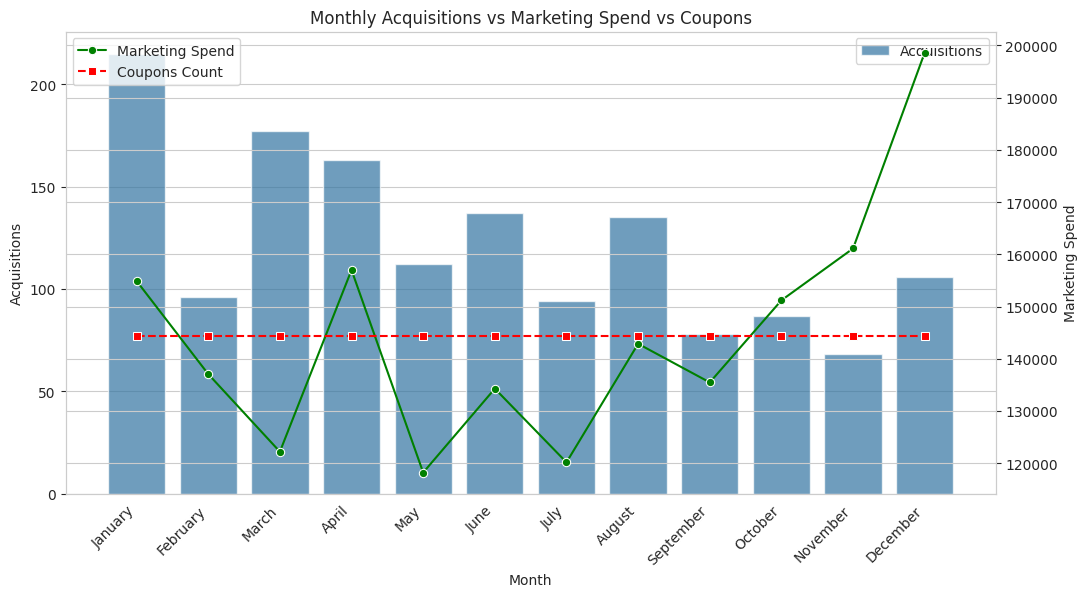


The chart indicates that coupon availability remains consistent throughout the year, while customer acquisition closely 
follows marketing spend patterns. This suggests that marketing expenditure has a greater influence on acquisition than 
coupons alone. Increasing or optimizing marketing spend during key periods may help maintain more stable and predictable 
customer acquisition levels.



In [79]:
# ******
# REMAINING QUESTIONS ARE ADDITIONAL, THEY WERE DONE AS I STARTED FOLLOWING THE APPROACH DOCUMENTATION, INSTEAD OF CASE-STUDY PAGE.
# REALIZED IT LATER THAT THE SEQUENCE IN BOTH PAGES ARE DIFFERENT
# ******

# 2. (From Approach Document) Analyze the data to determine if certain months consistently show higher or lower acquisition.
# How can the company capitalize on high-performing months and improve performance during slower periods?
# Hint: Building on your analysis from Question 1, look for recurring patterns or anomalies in monthly acquisition count.
# Hint: Consider how to leverage insights from high-performing months (e.g., specific marketing efforts, product launches)
# and what targeted interventions might stimulate demand during slower periods.


# Coupons
monthwise_coupons = discount_coupon_df.groupby("Month")["Coupon_Code"].count().reset_index(name="Coupons_Count")
monthwise_coupons["Month"] = pd.to_datetime(monthwise_coupons["Month"], format="%b").dt.strftime("%B")

# Marketting Spend
marketing_spend_df["Date"] = pd.to_datetime(marketing_spend_df["Date"], format="%m/%d/%Y")
marketing_spend_df["Month"] = marketing_spend_df["Date"].dt.month.map(month_map)
monthly_marketing_df = (marketing_spend_df.groupby("Month", as_index=False)[["Offline_Spend", "Online_Spend"]].sum())
monthly_marketing_df["Total"] = monthly_marketing_df["Offline_Spend"] + monthly_marketing_df["Online_Spend"]
monthly_marketing_df = monthly_marketing_df.sort_values("Month")

# Merge the data
merged_df = monthly_acquisitions.merge(monthly_marketing_df, on="Month", how="inner")
merged_df = merged_df.merge(monthwise_coupons, on="Month", how="inner")

# Plot the Chart
# plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

# BAR: Monthly Acquisitions
sns.barplot(x="Month", y="Acquisitions", data=merged_df, ax=ax1, alpha=0.7, label="Acquisitions")
ax1.set_ylabel("Acquisitions")
ax1.set_xlabel("Month")
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# LINE 1: Marketing Spend
ax2 = ax1.twinx()
sns.lineplot(x="Month", y="Total", data=merged_df, ax=ax2, color="green", marker="o", label="Marketing Spend")
ax2.set_ylabel("Marketing Spend")


# LINE 2: Coupons Count (scaled)
scale_factor = merged_df["Total"].mean() / merged_df["Coupons_Count"].mean()
sns.lineplot(x="Month",
             y=merged_df["Coupons_Count"] * scale_factor, data=merged_df, ax=ax2, color="red",
             linestyle="--", marker="s", label="Coupons Count")

plt.title("Monthly Acquisitions vs Marketing Spend vs Coupons")
plt.show()

print("""
The chart indicates that coupon availability remains consistent throughout the year, while customer acquisition closely
follows marketing spend patterns. This suggests that marketing expenditure has a greater influence on acquisition than
coupons alone. Increasing or optimizing marketing spend during key periods may help maintain more stable and predictable
customer acquisition levels.
""")


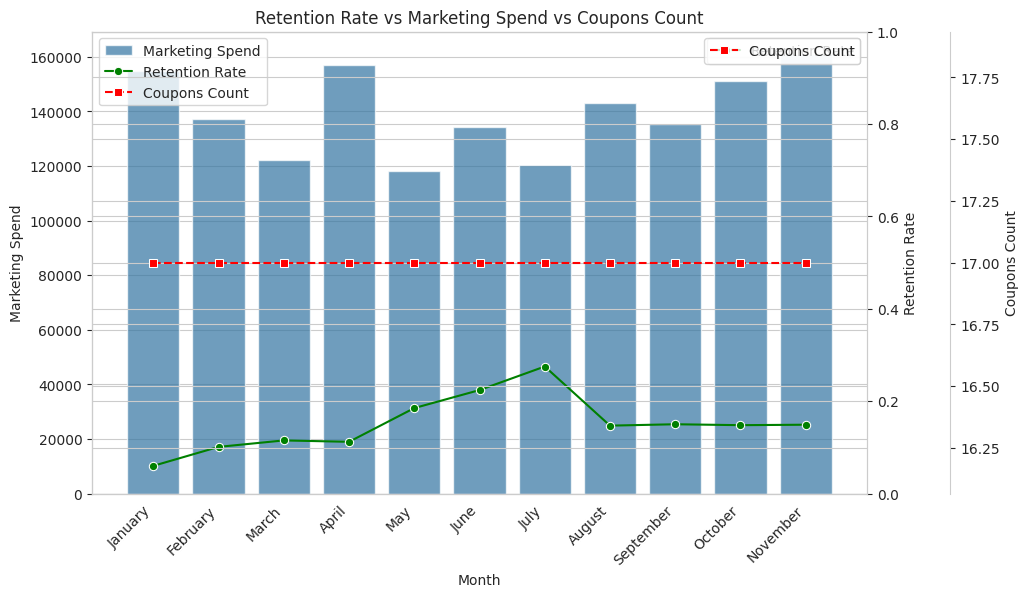


Customer retention varies significantly across months. January records the weakest retention rate at 6.0%, 
while July shows the strongest retention at 27.5%.

The chart indicates that higher marketing spend alone does not strongly correlate with improved customer retention.
Introducing or increasing targeted coupon incentives during low-retention months could help re-engage customers
and improve overall retention performance.



In [80]:
# ******
# REMAINING QUESTIONS ARE ADDITIONAL, THEY WERE DONE AS I STARTED FOLLOWING THE APPROACH DOCUMENTATION, INSTEAD OF CASE-STUDY PAGE.
# REALIZED IT LATER THAT THE SEQUENCE IN BOTH PAGES ARE DIFFERENT
# ******

# 3. (From Approach Document) Identify periods with the strongest and weakest retention rates. What strategies could be implemented
#     to improve retention during weaker months?
#     Hint: Retention isn’t just about who appeared again — it's about how many of this month's customers returned the next month,
#           as a percentage of the original month's customers. Think about comparing each month’s customer list to the next month’s,
#           and calculate what fraction was retained.
#           Monthly Retention rate = (Customers in Month X who returned in Month X+1) /  (total number of customers in month X)
#     Hint: For periods with weaker retention, consider what might lead to customer churn and what proactive measures could re-engage them.

# Find customers data for each month


# Merge the Rentention Data with Monthly Marketting
merged_retention_df = retention_data.merge(monthly_marketing_df, on="Month", how="inner")
merged_retention_df = merged_retention_df.merge(monthwise_coupons, on="Month", how="inner")


# Plot the Chart
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

# BAR: Monthly Acquisitions
sns.barplot(x="Month", y="Total", data=merged_retention_df, ax=ax1, alpha=0.7, label="Marketing Spend")
ax1.set_ylabel("Marketing Spend")
ax1.set_xlabel("Month")
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# LINE 1: Retention
ax2 = ax1.twinx()
sns.lineplot(x="Month", y="Retention_Rate", data=merged_retention_df, ax=ax2, color="green", marker="o", label="Retention Rate")
ax2.set_ylabel("Retention Rate")
ax2.set_ylim(0, 1)

# LINE 2: Coupons Count
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
sns.lineplot(x="Month", y="Coupons_Count", data=merged_retention_df, ax=ax3, color="red", linestyle="--",
             marker="s", label="Coupons Count")
ax3.set_ylabel("Coupons Count")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2 + lines_3,
    labels_1 + labels_2 + labels_3,
    loc="upper left"
)

plt.title("Retention Rate vs Marketing Spend vs Coupons Count")
plt.show()


weakest = retention_data.sort_values(by="Retention_Rate")[:1].iloc[0]
strongest = retention_data.sort_values(by="Retention_Rate")[-1:].iloc[0]
print(f"""
Customer retention varies significantly across months. {weakest["Month"]} records the weakest retention rate at {weakest["Retention_Rate"]:.1%},
while {strongest["Month"]} shows the strongest retention at {strongest["Retention_Rate"]:.1%}.

The chart indicates that higher marketing spend alone does not strongly correlate with improved customer retention.
Introducing or increasing targeted coupon incentives during low-retention months could help re-engage customers
and improve overall retention performance.
""")


